In [1]:
import pandas as pd
import yaml
import os
from os.path import join
from src.config import ROOT_DIR, RESULTS
%matplotlib inline

Project Directory: /data2/mito_lineage


In [2]:
import  matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.chdir(ROOT_DIR)

In [4]:
with open("parameters/2020_11_18_Croker_mito.yaml") as f:
    config = yaml.safe_load(f)

outdir = join(config["results"], "QC")
if not os.path.exists(outdir):
    os.mkdir(outdir)
    

config


samples = pd.read_table(config["samples"],sep=',', index_col=0)
samples = samples.dropna(axis=1)
for ind, val in samples.iterrows():
    samples.at[ind,'metrics'] = os.path.join(os.path.dirname(val['bam_f']),"summary.csv")

for ind, val in samples.iterrows():
    df = pd.read_csv(val["metrics"])
    df.index = [ind]
    df.index.name = "sample"
    if df.columns[0] in samples.columns:
        samples.loc[ind, df.columns] = df.loc[ind]
    else:
        samples = samples.merge(df, how='outer', left_index=True, right_index=True)
        
samples = samples.drop(labels=["bam_f", "metrics"], axis=1)

samples

,barcode_f,annotated_cells,bc_q30_bases_fract,cellranger-atac_version,cells_detected,frac_cut_fragments_in_peaks,frac_fragments_nfr,frac_fragments_nfr_or_nuc,frac_fragments_nuc,frac_fragments_overlapping_peaks,...,frac_waste_unmapped,median_fragments_per_cell,median_per_cell_total_library_complexity,median_per_cell_unique_fragments_at_30000_RRPC,median_per_cell_unique_fragments_at_50000_RRPC,num_fragments,r1_q30_bases_fract,r2_q30_bases_fract,si_q30_bases_fract,total_usable_fragments
sample,,,,,,,,,,,,,,,,,,,,,
PBMC_J,/data2/isshamie/mito_lineage/data/processed/mt...,743.0,0.816853,1.2.0,743.0,0.431328,0.456377,0.857266,0.400889,0.455840,...,0.003659,4600.0,5440.249850,807.212278,1228.462236,167910250.0,0.926115,0.867264,None,5693309.0
PBMC_P,/data2/isshamie/mito_lineage/data/processed/mt...,663.0,0.823013,1.2.0,663.0,0.622437,0.576425,0.917923,0.341498,0.642915,...,0.008394,4797.0,5111.126293,1232.088615,1802.309135,163008206.0,0.930662,0.871536,None,4524570.0


In [5]:
samples.columns.values

array(['barcode_f', 'annotated_cells', 'bc_q30_bases_fract',
       'cellranger-atac_version', 'cells_detected',
       'frac_cut_fragments_in_peaks', 'frac_fragments_nfr',
       'frac_fragments_nfr_or_nuc', 'frac_fragments_nuc',
       'frac_fragments_overlapping_peaks',
       'frac_fragments_overlapping_targets', 'frac_mapped_confidently',
       'frac_waste_chimeric', 'frac_waste_duplicate',
       'frac_waste_lowmapq', 'frac_waste_mitochondrial',
       'frac_waste_no_barcode', 'frac_waste_non_cell_barcode',
       'frac_waste_overall_nondup', 'frac_waste_total',
       'frac_waste_unmapped', 'median_fragments_per_cell',
       'median_per_cell_total_library_complexity',
       'median_per_cell_unique_fragments_at_30000_RRPC',
       'median_per_cell_unique_fragments_at_50000_RRPC', 'num_fragments',
       'r1_q30_bases_fract', 'r2_q30_bases_fract', 'si_q30_bases_fract',
       'total_usable_fragments'], dtype=object)

In [6]:
cols = ["cells_detected", 
        "median_fragments_per_cell", 
        "frac_fragments_overlapping_peaks",
        "frac_cut_fragments_in_peaks",
        "bc_q30_bases_fract"
       ]

In [7]:
samples_long = samples.reset_index().melt(id_vars="sample", value_vars=cols)
samples_long


,sample,variable,value
0,PBMC_J,cells_detected,743.000000
1,PBMC_P,cells_detected,663.000000
2,PBMC_J,median_fragments_per_cell,4600.000000
3,PBMC_P,median_fragments_per_cell,4797.000000
4,PBMC_J,frac_fragments_overlapping_peaks,0.455840
5,PBMC_P,frac_fragments_overlapping_peaks,0.642915
6,PBMC_J,frac_cut_fragments_in_peaks,0.431328
7,PBMC_P,frac_cut_fragments_in_peaks,0.622437
8,PBMC_J,bc_q30_bases_fract,0.816853
9,PBMC_P,bc_q30_bases_fract,0.823013


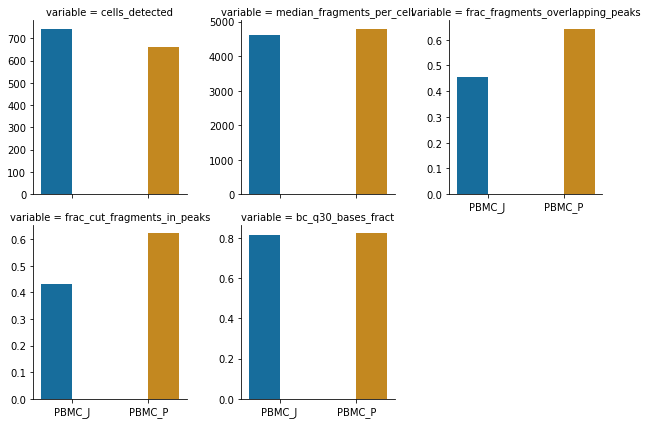

In [8]:
g = sns.FacetGrid(data=samples_long, col="variable", sharey=False, col_wrap=3, )
g.map_dataframe(sns.barplot, x="sample", y="value", hue="sample", palette="colorblind")
#plt.legend(bbox_to_anchor=(1.05, 1), title="Ligand", loc='upper left')
plt.savefig(join(outdir, "QC.png"))

### Load in published Lareau et al dataset 

In [9]:
samples_Lar = pd.DataFrame({"bam_f": ["/data2/isshamie/mito_lineage/data/processed/mtscATAC/Lareau_2020/PBMC_rep1/outs/possorted_bam.bam",
                                 "/data2/isshamie/mito_lineage/data/processed/mtscATAC/Lareau_2020/CD34_rep1/outs/possorted_bam.bam"]},
                            index=["PBMC", "CD34"])
samples_Lar.index = samples_Lar.index.rename("sample")
samples_Lar = samples_Lar.dropna(axis=1)
for ind, val in samples_Lar.iterrows():
    samples_Lar.at[ind,'metrics'] = os.path.join(os.path.dirname(val['bam_f']),"summary.csv")

all_df = []
for ind, val in samples_Lar.iterrows():
    df = pd.read_csv(val["metrics"])
    df.index = [ind]
    df.index.name = "sample"
    all_df.append(df)
    #if df.columns[0] in samples_Lar.columns:
    #    samples_Lar.loc[ind, df.columns] = df.loc[ind]
    #else:
    #    samples_Lar = samples_Lar.merge(df, how='outer', left_index=True, right_index=True)
        
#samples_Lar = samples_Lar.drop(labels=["bam_f", "metrics"], axis=1)

#samples_Lar
samples_Lar = pd.concat(all_df)

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [10]:
samples_Lar.columns.values

array(['annotated_cells', 'bc_q30_bases_fract', 'cellranger-atac_version',
       'cells_detected', 'frac_cut_fragments_in_peaks',
       'frac_fragments_nfr', 'frac_fragments_nfr_or_nuc',
       'frac_fragments_nuc', 'frac_fragments_overlapping_peaks',
       'frac_fragments_overlapping_targets', 'frac_mapped_confidently',
       'frac_waste_chimeric', 'frac_waste_duplicate',
       'frac_waste_lowmapq', 'frac_waste_mitochondrial',
       'frac_waste_no_barcode', 'frac_waste_non_cell_barcode',
       'frac_waste_overall_nondup', 'frac_waste_total',
       'frac_waste_unmapped', 'median_fragments_per_cell',
       'median_per_cell_unique_fragments_at_30000_RRPC',
       'median_per_cell_unique_fragments_at_50000_RRPC', 'num_fragments',
       'r1_q30_bases_fract', 'r2_q30_bases_fract', 'si_q30_bases_fract',
       'total_usable_fragments'], dtype=object)

In [11]:
all_samples = pd.concat((samples, samples_Lar))
all_samples["data"] = "Lareau et al 2020"
all_samples.loc[samples.index,"data"]="Current"

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [12]:
all_samples_long = all_samples.reset_index().melt(id_vars=["sample", "data"], value_vars=cols)
all_samples_long = all_samples_long.dropna(axis=0)
all_samples_long["data"] = all_samples_long["data"].astype(str)
all_samples_long

,sample,data,variable,value
0,PBMC_J,Current,cells_detected,743.000000
1,PBMC_P,Current,cells_detected,663.000000
2,PBMC,Lareau et al 2020,cells_detected,6680.000000
3,CD34,Lareau et al 2020,cells_detected,4453.000000
4,PBMC_J,Current,median_fragments_per_cell,4600.000000
5,PBMC_P,Current,median_fragments_per_cell,4797.000000
6,PBMC,Lareau et al 2020,median_fragments_per_cell,7513.500000
7,CD34,Lareau et al 2020,median_fragments_per_cell,19110.000000
8,PBMC_J,Current,frac_fragments_overlapping_peaks,0.455840
9,PBMC_P,Current,frac_fragments_overlapping_peaks,0.642915


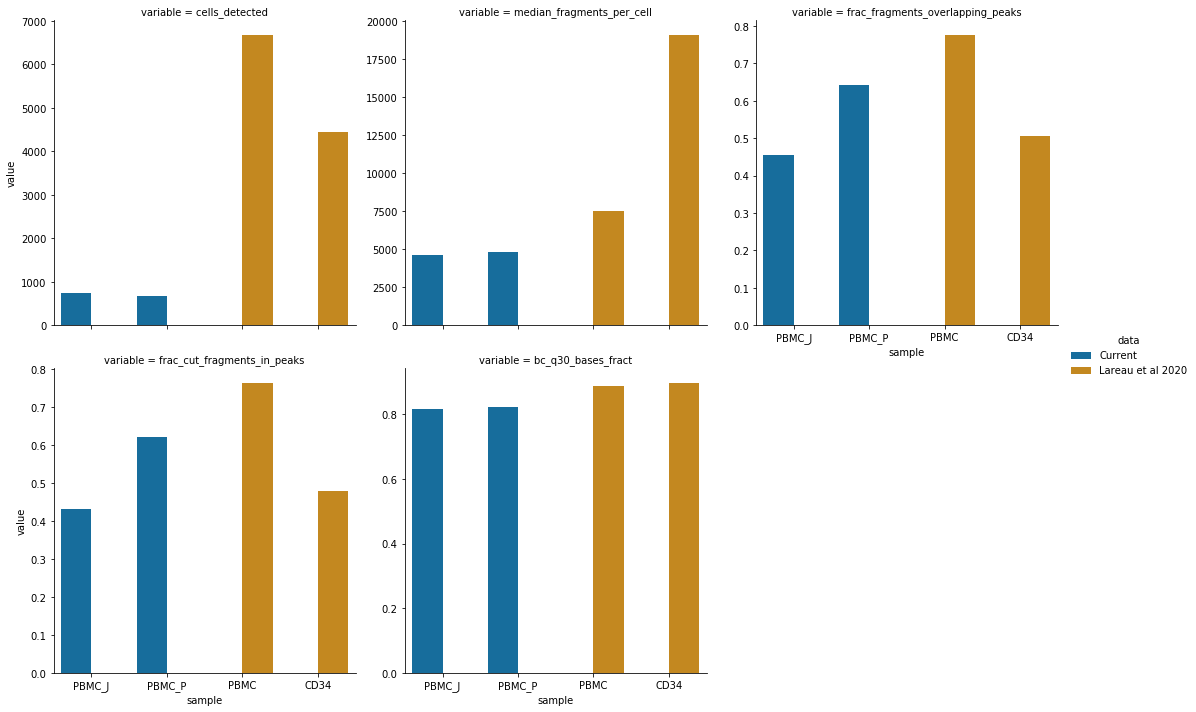

In [13]:
sns.catplot(x="sample", y="value", col="variable", hue="data", data=all_samples_long, kind='bar', col_wrap=3, 
            sharey=False, palette="colorblind")
plt.savefig(join(outdir, "QC_lareau.png"))